In [1]:
from lib.data import CombinedMegaPlantDataset
from lib.config import Directories
from PIL import Image
from torchvision import transforms
import json

from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from iragca.matplotlib import Styles
from lib.config import Directories

plt.style.use(Styles.ML.value)

IMAGE_SIZE = (32, 32)
transform_pipeline = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = CombinedMegaPlantDataset(data_path=Directories.INTERIM_DATA_DIR.value / "leaves", transforms=transform_pipeline)

In [2]:
from collections import defaultdict

freq_table = defaultdict(int)
for sample, label in dataset:
    freq_table[label] += 1


<Axes: >

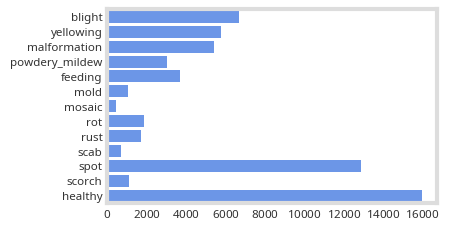

In [3]:
class_int_map = {v: k for k, v in dataset.CLASS_MAP.items()}
sns.barplot(y=[class_int_map[i] for i in freq_table.keys()], x=list(freq_table.values()), orient='h')

In [4]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, channels: int, output_dim: int = 1):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [5]:
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 32

train_data, val_data, test_data = random_split(dataset, [0.7, 0.2, 0.1])

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [6]:
for sample, label in train_loader:
    print(sample.shape, label.shape)
    print(sample, label)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])
tensor([[[[0.5529, 0.5569, 0.5647,  ..., 0.6392, 0.6431, 0.6471],
          [0.5569, 0.5569, 0.5647,  ..., 0.6275, 0.6431, 0.6510],
          [0.5529, 0.5608, 0.5725,  ..., 0.6314, 0.6392, 0.6353],
          ...,
          [0.5922, 0.6000, 0.6078,  ..., 0.6588, 0.6667, 0.6627],
          [0.5843, 0.6000, 0.6039,  ..., 0.6510, 0.6627, 0.6588],
          [0.6000, 0.5843, 0.5922,  ..., 0.6353, 0.6392, 0.6431]],

         [[0.3922, 0.3961, 0.4039,  ..., 0.4627, 0.4667, 0.4706],
          [0.3961, 0.3961, 0.4039,  ..., 0.4510, 0.4667, 0.4745],
          [0.3922, 0.4000, 0.4118,  ..., 0.4549, 0.4627, 0.4588],
          ...,
          [0.4431, 0.4510, 0.4588,  ..., 0.4980, 0.5059, 0.5020],
          [0.4353, 0.4510, 0.4549,  ..., 0.4941, 0.5020, 0.5020],
          [0.4510, 0.4353, 0.4431,  ..., 0.4745, 0.4824, 0.4863]],

         [[0.3765, 0.3804, 0.3882,  ..., 0.4510, 0.4549, 0.4588],
          [0.3804, 0.3804, 0.3882,  ..., 0.4392, 0.4549, 0.4627

In [7]:
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from iragca.ml import RunLogger
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import f1_score, accuracy_score

model = SimpleCNN(channels=3, output_dim=len(dataset.CLASS_MAP))
optimizer = SGD(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
EPOCHS = 50
THRESHOLD = 0.5

def train(model, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=True, 
        unit="epoch", 
        desc="Epochs"
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        train_preds, train_targets = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            train_pred = outputs.argmax(dim=1).cpu().numpy()
            train_target = targets.cpu().numpy()
            train_preds.extend(train_pred)
            train_targets.extend(train_target)

        train_loss = total_loss / len(train_loader)
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        train_acc = accuracy_score(train_targets, train_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_preds, val_targets = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_pred = outputs.argmax(dim=1).cpu().numpy()
                val_target = targets.cpu().numpy()
                val_preds.extend(val_pred)
                val_targets.extend(val_target)

            val_loss = val_loss / len(val_loader)
            val_f1 = f1_score(val_targets, val_preds, average='weighted')
            val_acc = accuracy_score(val_targets, val_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_f1': train_f1,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_f1': val_f1,
            'val_acc': val_acc,
            }, epoch)

    return logger

logger = train(model, optimizer, criterion, epochs=EPOCHS)

Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Training:   0%|          | 0/1318 [00:00<?, ?it/s]

Validating:   0%|          | 0/377 [00:00<?, ?it/s]

Text(0.5, 1.0, 'F1 Score over Epochs')

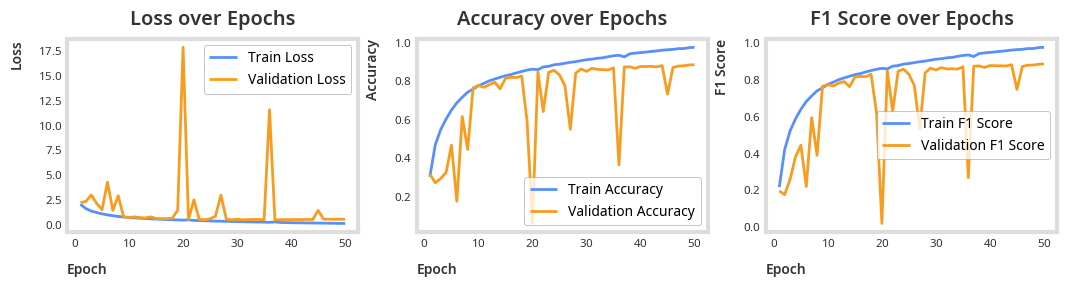

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))

sns.lineplot(x=logger.steps, y=logger.train_loss, label='Train Loss', ax=ax[0])
sns.lineplot(x=logger.steps, y=logger.val_loss, label='Validation Loss', ax=ax[0])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss over Epochs')

sns.lineplot(x=logger.steps, y=logger.train_acc, label='Train Accuracy', ax=ax[1])
sns.lineplot(x=logger.steps, y=logger.val_acc, label='Validation Accuracy', ax=ax[1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy over Epochs')

sns.lineplot(x=logger.steps, y=logger.train_f1, label='Train F1 Score', ax=ax[2])
sns.lineplot(x=logger.steps, y=logger.val_f1, label='Validation F1 Score', ax=ax[2])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('F1 Score')
ax[2].set_title('F1 Score over Epochs')

In [12]:
MDOEL_NAME = "combined_identification_model"
torch.save(model.state_dict(), Directories.MODELS_DIR.value / f"{MDOEL_NAME}.pth")

with open(Directories.MODELS_DIR.value / f"{MDOEL_NAME}_train_results.json", "w") as f:
    json.dump(logger.get_logs(), f)

In [13]:
model2 = SimpleCNN(channels=3, output_dim=len(dataset.CLASS_MAP))

model2.load_state_dict(torch.load(Directories.MODELS_DIR.value / f"{MDOEL_NAME}.pth"))

<All keys matched successfully>

In [14]:

test_preds, test_targets = [], []
model2.eval()
model2.to("cuda")
for inputs, targets in tqdm(test_loader, desc="Evaluating"):
    inputs, targets = inputs.to("cuda"), targets.to("cuda")
    with torch.no_grad():
        outputs = model2(inputs)
        test_pred = outputs.argmax(dim=1)
        test_preds.extend(test_pred.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

Evaluating:   0%|          | 0/189 [00:00<?, ?it/s]

In [17]:
test_accuracy = accuracy_score(test_targets, test_preds)
test_f1 = f1_score(test_targets, test_preds, average='weighted')

In [18]:
print(test_accuracy, test_f1)

0.8807308970099668 0.8807796543937321


In [19]:
print(classification_report(test_targets, test_preds))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       618
           1       0.94      0.94      0.94       585
           2       0.96      0.96      0.96       556
           3       0.93      0.88      0.90       296
           4       0.81      0.81      0.81       361
           5       0.82      0.79      0.80       109
           6       0.88      0.69      0.77        52
           7       0.81      0.80      0.81       179
           8       0.90      0.83      0.86       174
           9       0.62      0.66      0.64        73
          10       0.83      0.83      0.83      1256
          11       0.92      0.88      0.90        95
          12       0.93      0.94      0.94      1666

    accuracy                           0.88      6020
   macro avg       0.86      0.83      0.84      6020
weighted avg       0.88      0.88      0.88      6020

